# Universidade Federal do Ceará
### Residência em Segurança da Informação


                                Equipe: Lorena da Silva Medeiros (543039)
                                        Lucelia Lima Souza (543024)
                                        Nathalia Cavalcanti Martins (543029)
                                        
                                        
### Projeto de ML com a base IoT-23

##### Preparação inicial do ambiente

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [2]:
filepath = 'base.csv'
df_c = pd.read_csv(filepath, low_memory=False)

In [3]:
df_c.loc[(df_c.label == '-   Malicious   PartOfAHorizontalPortScan'), 'label'] = 'PartOfAHorizontalPortScan'
df_c.loc[(df_c.label == '(empty)   Malicious   PartOfAHorizontalPortScan'), 'label'] = 'PartOfAHorizontalPortScan'
df_c.loc[(df_c.label == '-   Malicious   Okiru'), 'label'] = 'Okiru'
df_c.loc[(df_c.label == '(empty)   Malicious   Okiru'), 'label'] = 'Okiru'
df_c.loc[(df_c.label == '-   Benign   -'), 'label'] = 'Benign'
df_c.loc[(df_c.label == '(empty)   Benign   -'), 'label'] = 'Benign'
df_c.loc[(df_c.label == '-   Malicious   DDoS'), 'label'] = 'DDoS'
df_c.loc[(df_c.label == '-   Malicious   C&C'), 'label'] = 'C&C'
df_c.loc[(df_c.label == '(empty)   Malicious   C&C'), 'label'] = 'C&C'
df_c.loc[(df_c.label == '-   Malicious   Attack'), 'label'] = 'Attack'
df_c.loc[(df_c.label == '(empty)   Malicious   Attack'), 'label'] = 'Attack'
df_c.loc[(df_c.label == '-   Malicious   C&C-HeartBeat'), 'label'] = 'C&C-HeartBeat'
df_c.loc[(df_c.label == '(empty)   Malicious   C&C-HeartBeat'), 'label'] = 'C&C-HeartBeat'
df_c.loc[(df_c.label == '-   Malicious   C&C-FileDownload'), 'label'] = 'C&C-FileDownload'
df_c.loc[(df_c.label == '-   Malicious   C&C-Torii'), 'label'] = 'C&C-Torii'
df_c.loc[(df_c.label == '-   Malicious   C&C-HeartBeat-FileDownload'), 'label'] = 'C&C-HeartBeat-FileDownload'
df_c.loc[(df_c.label == '-   Malicious   FileDownload'), 'label'] = 'FileDownload'
df_c.loc[(df_c.label == '-   Malicious   C&C-Mirai'), 'label'] = 'C&C-Mirai'
df_c.loc[(df_c.label == '-   Malicious   Okiru-Attack'), 'label'] = 'Okiru-Attack'

In [4]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444674 entries, 0 to 1444673
Data columns (total 21 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   ts             1444674 non-null  float64
 1   uid            1444674 non-null  object 
 2   id.orig_h      1444674 non-null  object 
 3   id.orig_p      1444674 non-null  float64
 4   id.resp_h      1444674 non-null  object 
 5   id.resp_p      1444674 non-null  float64
 6   proto          1444674 non-null  object 
 7   service        1444674 non-null  object 
 8   duration       1444674 non-null  object 
 9   orig_bytes     1444674 non-null  object 
 10  resp_bytes     1444674 non-null  object 
 11  conn_state     1444674 non-null  object 
 12  local_orig     1444674 non-null  object 
 13  local_resp     1444674 non-null  object 
 14  missed_bytes   1444674 non-null  float64
 15  history        1444674 non-null  object 
 16  orig_pkts      1444674 non-null  float64
 17  orig_ip_

##### Dropar features e Labels

- Features a serem dropadas: ts, uid, id.orig_h, id.resp_h, local_orig, local_resp
- Escolher uma para apagar: resp_pkts, resp_ip_bytes (são proporcionais). Escolhida: resp_pkts
- Labels com menos de 50 ataques

In [5]:
# sem dropar timestamp (ts) e history
df_c = df_c.drop(columns=['ts','uid', 'id.orig_h', 'id.resp_h', 'local_orig', 'local_resp', 'resp_pkts'])

In [6]:
df_c.shape

(1444674, 14)

In [7]:
df_c['label'].value_counts()

PartOfAHorizontalPortScan     825939
Okiru                         262690
Benign                        197809
DDoS                          138777
C&C                            15100
Attack                          3915
C&C-HeartBeat                    349
C&C-FileDownload                  43
C&C-Torii                         30
FileDownload                      13
C&C-HeartBeat-FileDownload         8
C&C-Mirai                          1
Name: label, dtype: int64

In [8]:
list = ['C&C-FileDownload', 'C&C-Torii', 'FileDownload', 'C&C-HeartBeat-FileDownload', 'C&C-Mirai']
df_c.drop(df_c[df_c.label.isin(list)].index, axis = 0, inplace = True)

In [9]:
df_c['label'].value_counts()

PartOfAHorizontalPortScan    825939
Okiru                        262690
Benign                       197809
DDoS                         138777
C&C                           15100
Attack                         3915
C&C-HeartBeat                   349
Name: label, dtype: int64

## Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df2 = df_c.copy()

In [13]:
#del df_c

In [14]:
# Codificar a variável categórica usando pd.get_dummies
df2 = pd.get_dummies(df2, columns=['proto'])
df2 = pd.get_dummies(df2, columns=['conn_state'])
df2 = pd.get_dummies(df2, columns=['history'])
df2= pd.get_dummies(df2, columns=['service'])

In [15]:
# Substituir - por Nan
df2.replace('-', np.nan, inplace = True)

In [16]:
# Transformar variáveis Object em Float
df2['duration'] = df2['duration'].astype('float')
df2['orig_bytes'] = df2['orig_bytes'].astype('float')
df2['resp_bytes'] = df2['resp_bytes'].astype('float')

In [17]:
#df['id.orig_p'] = df['id.orig_p'].astype('int')
#df['id.resp_p'] = df['id.resp_p'].astype('int')

In [18]:
# Tratando as features id_orig_p e id_resp_p com FeatureHasher
from sklearn.feature_extraction import FeatureHasher

# Inicializa o FeatureHasher
hasher = FeatureHasher(n_features=2**5)

dict_orig_p = df2[['id.orig_p']].to_dict(orient='records')
dict_resp_p = df2[['id.resp_p']].to_dict(orient='records')

# Converte as colunas categóricas usando o FeatureHasher
hashed_id_orig_p = hasher.transform(dict_orig_p)
hashed_id_resp_p = hasher.transform(dict_resp_p)

# Cria um novo DataFrame com as features convertidas
id_orig_p_df2 = pd.DataFrame.sparse.from_spmatrix(hashed_id_orig_p)
id_resp_p_df2 = pd.DataFrame.sparse.from_spmatrix(hashed_id_resp_p)

In [19]:
# Renomeando as colunas
for i in range(2**5):
    id_orig_p_df2 = id_orig_p_df2.rename(columns={i: 'id_orig_p_'+str(i)})
    id_resp_p_df2 = id_resp_p_df2.rename(columns={i: 'id_resp_p_'+str(i)})
hasher_p = pd.concat([id_orig_p_df2, id_resp_p_df2], axis=1)


In [20]:
# Concatenando as novas colunas
df2 = df2.drop(columns=['id.orig_p', 'id.resp_p']).reset_index().drop(columns=['index'])

In [21]:
df2 = pd.concat([hasher_p, df2], axis=1)

In [22]:
X = df2.drop(['label'], axis=1)
y = df2['label']
# Definindo o modelo de cross-validation aninhado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
def outros_models (X_train, y_train, X_test, y_test, metrics, conf_matrices):
    model = DecisionTreeClassifier(random_state=42)

    params = {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
        
    }

    grid_search = GridSearchCV(model, param_grid=params, scoring="accuracy", cv=cv, error_score='raise')
    result = grid_search.fit(X_train, y_train)
    best_model = result.best_estimator_

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, zero_division=1)
    explainer = shap.TreeExplainer(best_model, feature_names=X_train.columns, 
                                   feature_perturbation="tree_path_dependent")
    shap_values = explainer.shap_values(X_test)
    
    metric_avg = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

    metrics[0].append(metric_avg['accuracy'])
    metrics[1].append(metric_avg['macro avg']['precision'])
    metrics[2].append(metric_avg['macro avg']['recall'])
    metrics[3].append(metric_avg['macro avg']['f1-score'])

    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    conf_matrices.append(conf_matrix)

    return report, shap_values


def decision_tree(X, y):
    accuracy = []
    precision = []
    recall = []
    f1_score = []
    metrics = [accuracy, precision, recall, f1_score]
    conf_matrices = []

    # Realizando o cross-validation aninhado
    reports = []
    shap_values_list = []
    
    class_labels = ['Attack', 'Benign', 'C&C', 'C&C-Heart-Beat', 'DDos', 'Okiru', 'PorHoriztScan']
    
    
    for train_index, test_index in cv.split(X, y):
        # Separar os dados de treino e teste
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        median_duration = X_train['duration'].median()
        median_orig_bytes = X_train['orig_bytes'].median()
        median_resp_bytes = X_train['resp_bytes'].median()

        # Imputar a mediana nos dados de treino
        X_train = X_train.fillna({'duration':median_duration, 'orig_bytes':median_orig_bytes, 'resp_bytes':median_resp_bytes})

        # Imputar a mediana nos dados de teste
        X_test = X_test.fillna({'duration':median_duration, 'orig_bytes':median_orig_bytes, 'resp_bytes':median_resp_bytes})
     
        report, shap_values = outros_models(X_train, y_train, X_test, y_test, metrics, conf_matrices)
        reports.append(report)
        shap_values_list.append(shap_values)
        
        print(f"Fold {len(conf_matrices)}:")
        print("Confusion Matrix:")
        print(conf_matrices[-1])
        print(report)
        shap.summary_plot(shap_values, X_test, class_names=class_labels)

    return metrics, conf_matrices

### Salvando os resultados das métricas, shap como arquivo pickle

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

Fold 1:
Confusion Matrix:
[[9.96168582e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.83141762e-03]
 [0.00000000e+00 9.79551084e-01 1.26383904e-04 0.00000000e+00
  5.05535615e-05 0.00000000e+00 2.02719782e-02]
 [0.00000000e+00 6.62251656e-04 9.98675497e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.62251656e-04]
 [0.00000000e+00 1.42857143e-02 0.00000000e+00 9.85714286e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.60295442e-05 0.00000000e+00 0.00000000e+00
  9.99963970e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.12477904e-02 1.21074170e-05 6.05370850e-06
  0.00000000e+00 0.00000000e+00 9.88734048e-01]]
                           precision    recall  f1-score   support

                   Attack       1.00      1.00      1.00       783
                   Benign       0.95      0.98      0.97     39562
 

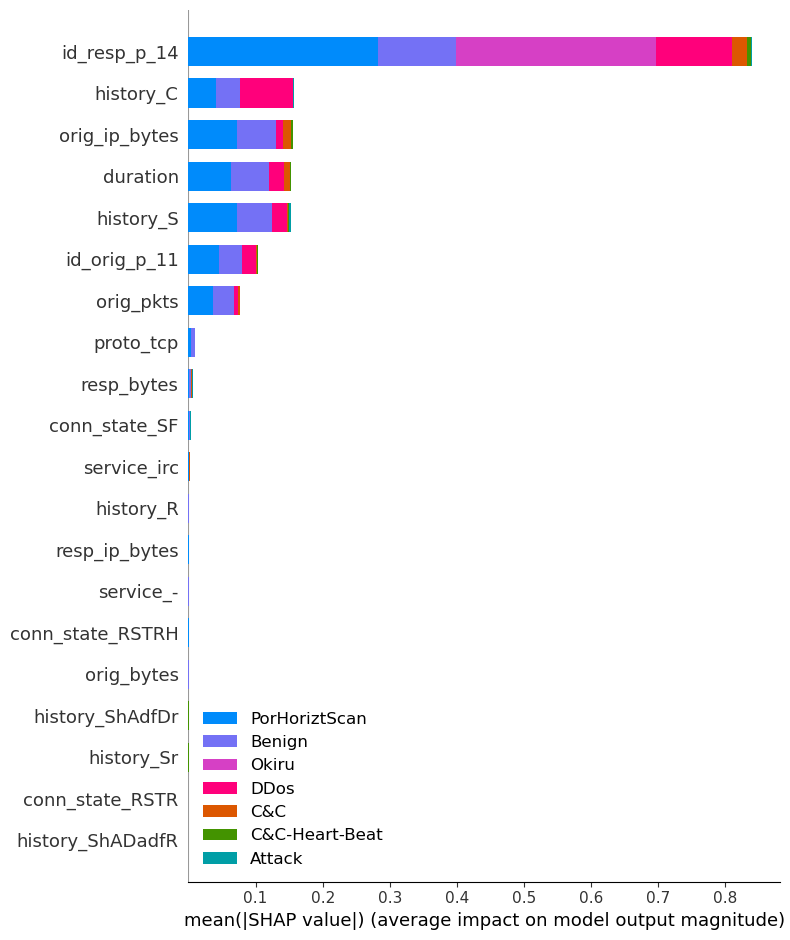

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

Fold 2:
Confusion Matrix:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.05535615e-05 9.79677468e-01 5.05535615e-05 5.05535615e-05
  0.00000000e+00 0.00000000e+00 2.01708710e-02]
 [0.00000000e+00 1.65562914e-03 9.97682119e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.62251656e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.60295442e-05 3.60295442e-05 0.00000000e+00
  9.99927941e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [6.05370850e-06 1.08482456e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.89145701e-01]]
                           precision    recall  f1-score   support

                   Attack       1.00      1.00      1.00       783
                   Benign       0.96      0.98      0.97     39562
 

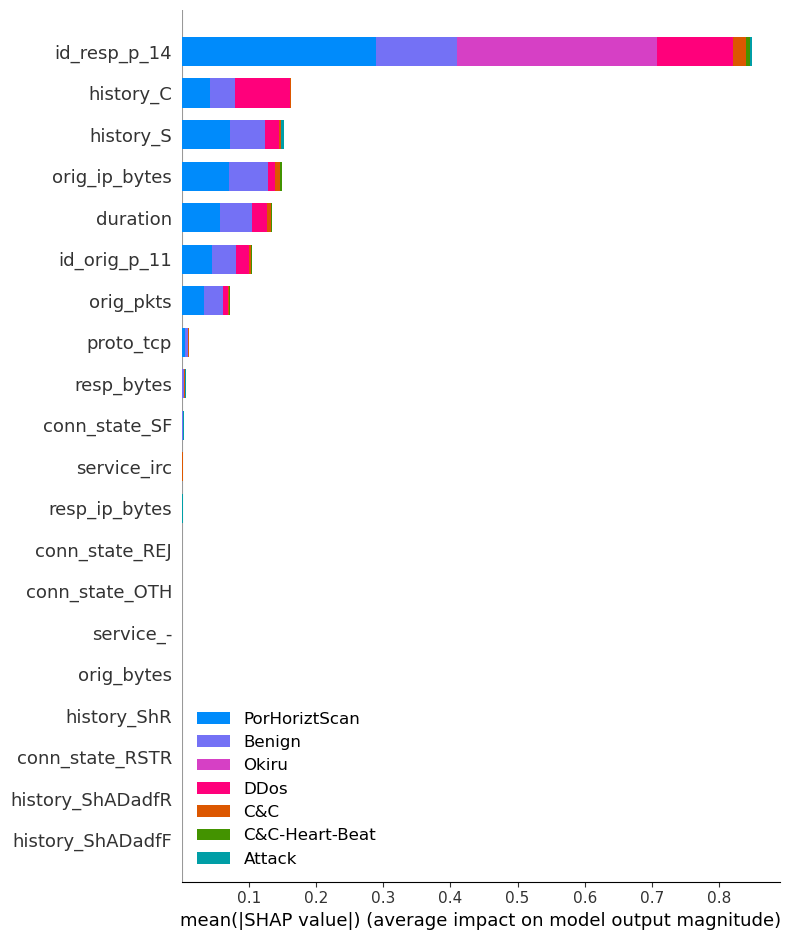

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

Fold 3:
Confusion Matrix:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.80334665e-01 7.58303422e-05 2.52767807e-05
  2.52767807e-05 0.00000000e+00 1.95389515e-02]
 [0.00000000e+00 3.31125828e-04 9.98013245e-01 6.62251656e-04
  0.00000000e+00 0.00000000e+00 9.93377483e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.81611255e-05 1.06847955e-02 6.05370850e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.89290990e-01]]
                           precision    recall  f1-score   support

                   Attack       1.00      1.00      1.00       783
                   Benign       0.96      0.98      0.97     39562
 

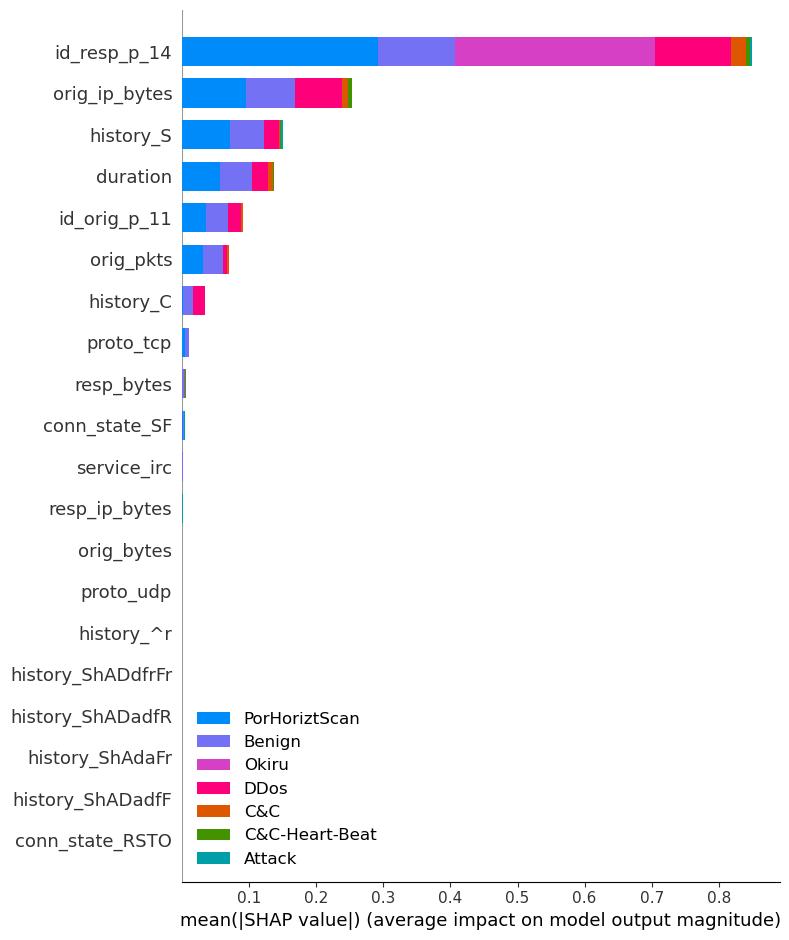

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

Fold 4:
Confusion Matrix:
[[9.98722861e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.27713921e-03]
 [2.52774197e-05 9.79474735e-01 1.01109679e-04 7.58322590e-05
  0.00000000e+00 0.00000000e+00 2.03230454e-02]
 [0.00000000e+00 3.31125828e-04 9.99668874e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.85714286e-01
  0.00000000e+00 0.00000000e+00 1.42857143e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [6.05370850e-06 1.05152917e-02 1.21074170e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.89466547e-01]]
                           precision    recall  f1-score   support

                   Attack       1.00      1.00      1.00       783
                   Benign       0.96      0.98      0.97     39561
 

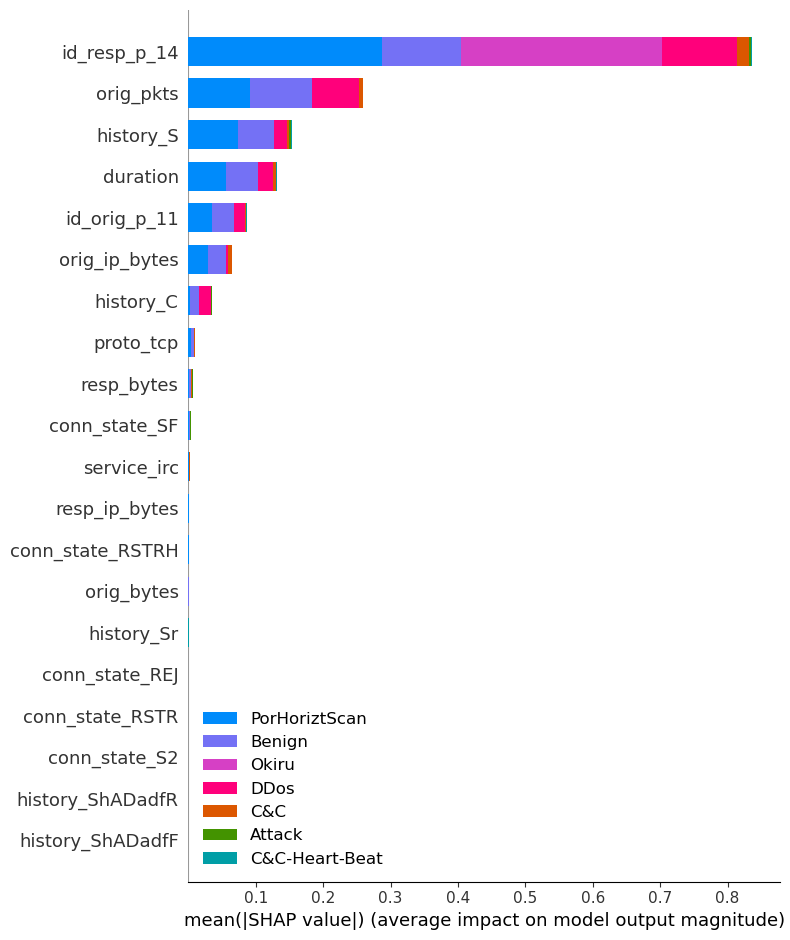

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

Fold 5:
Confusion Matrix:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.52767807e-05 9.79171933e-01 1.76937465e-04 2.52767807e-05
  2.52767807e-05 0.00000000e+00 2.05752995e-02]
 [0.00000000e+00 1.98675497e-03 9.97682119e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.31125828e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60282461e-05
  9.99963972e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.11328373e-02 6.05374515e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.88861109e-01]]
                           precision    recall  f1-score   support

                   Attack       1.00      1.00      1.00       783
                   Benign       0.95      0.98      0.97     39562
 

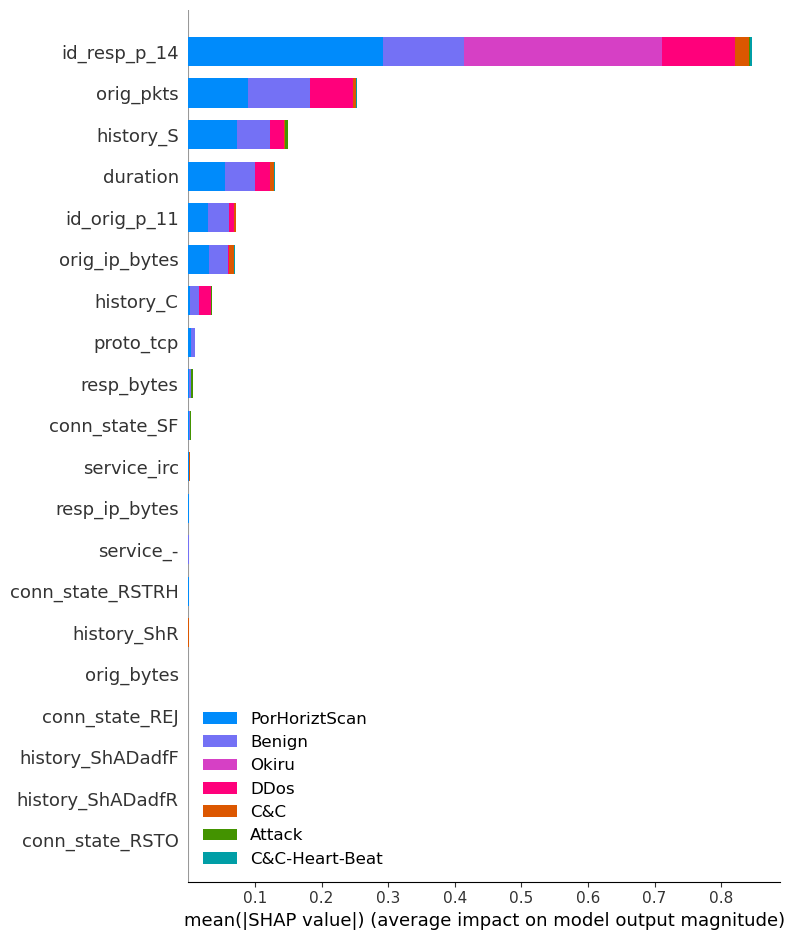

Acurácia: 0.991 +- 0.0
Precisão: 0.988 +- 0.001
Recall: 0.994 +- 0.001
F1-score: 0.991 +- 0.001
Matriz de Confusão (Média):
[[0.999 0.    0.    0.    0.    0.    0.001]
 [0.    0.98  0.    0.    0.    0.    0.02 ]
 [0.    0.001 0.998 0.    0.    0.    0.001]
 [0.    0.003 0.    0.994 0.    0.    0.003]
 [0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.011 0.    0.    0.    0.    0.989]]


In [24]:
metrics, conf_matrices = decision_tree(X, y)

accuracy_mean = np.mean(metrics[0])
accuracy_std = np.std(metrics[0])
precision_mean = np.mean(metrics[1])
precision_std = np.std(metrics[1])
recall_mean = np.mean(metrics[2])
recall_std = np.std(metrics[2])
f1_score_mean = np.mean(metrics[3])
f1_score_std = np.std(metrics[3])

print(f"Acurácia: {round(accuracy_mean, 3)} +- {round(accuracy_std, 3)}")
print(f"Precisão: {round(precision_mean, 3)} +- {round(precision_std, 3)}")
print(f"Recall: {round(recall_mean, 3)} +- {round(recall_std, 3)}")
print(f"F1-score: {round(f1_score_mean, 3)} +- {round(f1_score_std, 3)}")

num_classes = 7
conf_matrices_filled = []
for conf_matrix in conf_matrices:
    conf_matrix_filled = np.zeros((num_classes, num_classes))
    conf_matrix_filled[:conf_matrix.shape[0], :conf_matrix.shape[1]] = conf_matrix
    conf_matrices_filled.append(conf_matrix_filled)

conf_matrix_mean = np.mean(conf_matrices_filled, axis=0)

class_labels = ['Attack', 'Benign', 'C&C', 'C&C-Heart-Beat', 'DDos', 'Okiru', 'PorHoriztScan']

print("Matriz de Confusão (Média):")
np.set_printoptions(precision=3, suppress=True)
print(conf_matrix_mean)

# Salvar os resultados em um arquivo pickle
results = {
    'metrics': metrics,
    'conf_matrices': conf_matrices,
    'conf_matrix_mean': conf_matrix_mean
}

with open('results_dt.pkl', 'wb') as f:
    pickle.dump(results, f)

### Carregado o arquivo pickle com o resultado da Matriz de Confusão - Média

Acurácia: 0.991 +- 0.0
Precisão: 0.988 +- 0.001
Recall: 0.994 +- 0.001
F1-score: 0.991 +- 0.001
Matriz de Confusão (Média):
[[0.999 0.    0.    0.    0.    0.    0.001]
 [0.    0.98  0.    0.    0.    0.    0.02 ]
 [0.    0.001 0.998 0.    0.    0.    0.001]
 [0.    0.003 0.    0.994 0.    0.    0.003]
 [0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.011 0.    0.    0.    0.    0.989]]


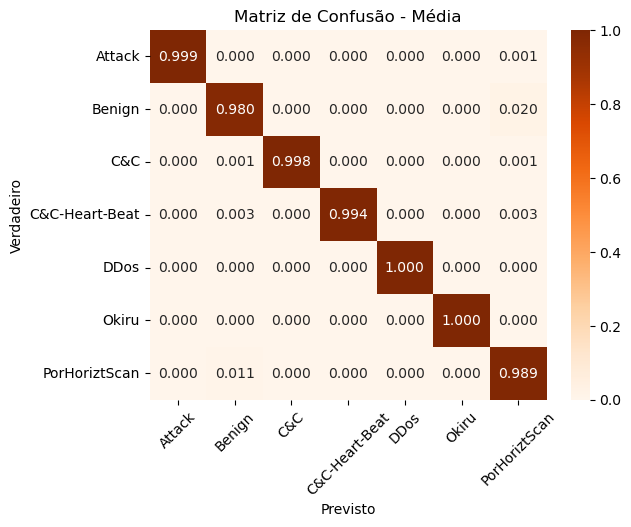

In [25]:
# Carregar os resultados do arquivo pickle
with open('results_dt.pkl', 'rb') as f:
    results = pickle.load(f)

metrics = results['metrics']
conf_matrices = results['conf_matrices']
conf_matrix_mean = results['conf_matrix_mean']

# Acessar os resultados
# imprimir a média e o desvio padrão das métricas
accuracy_mean = np.mean(metrics[0])
accuracy_std = np.std(metrics[0])
precision_mean = np.mean(metrics[1])
precision_std = np.std(metrics[1])
recall_mean = np.mean(metrics[2])
recall_std = np.std(metrics[2])
f1_score_mean = np.mean(metrics[3])
f1_score_std = np.std(metrics[3])

print(f"Acurácia: {round(accuracy_mean, 3)} +- {round(accuracy_std, 3)}")
print(f"Precisão: {round(precision_mean, 3)} +- {round(precision_std, 3)}")
print(f"Recall: {round(recall_mean, 3)} +- {round(recall_std, 3)}")
print(f"F1-score: {round(f1_score_mean, 3)} +- {round(f1_score_std, 3)}")

print("Matriz de Confusão (Média):")
np.set_printoptions(precision=3, suppress=True)
print(conf_matrix_mean)

ax = sns.heatmap(conf_matrix_mean, annot=True, cmap="Oranges", fmt=".3f", 
                 xticklabels=class_labels, yticklabels=class_labels, cbar=True)
ax.set_xticklabels(class_labels, rotation=45)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Média")
plt.show()